In [1]:
import numpy as np
import torch
import lightkurve as lk

print(f"NumPy: {np.__version__}")
print(f"PyTorch: {torch.__version__}")
print(f"Lightkurve: {lk.__version__}")
# print(f"CUDA available: {torch.cuda.is_available()}")

lc = lk.search_lightcurve("Kepler-10", author="Kepler", cadence="long")
print(f"Found {len(lc)} light curves for Kepler-10.")

c:\Users\mikem\source\repos\AIExoplanetFinder\.venv\Lib\site-packages\lightkurve\prf\__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


NumPy: 2.4.1
PyTorch: 2.9.1+cpu
Lightkurve: 2.5.1
Found 15 light curves for Kepler-10.


In [2]:
import pandas as pd

url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps+where+disc_facility+like+'%25Kepler%25'+and+default_flag=1&format=csv"
planets_df = pd.read_csv(url)

print(f"Found {len(planets_df)} confirmed Kepler planets")

Found 2783 confirmed Kepler planets


C:\Users\mikem\AppData\Local\Temp\ipykernel_60012\3084108069.py:4: DtypeWarning: Columns (3,184) have mixed types. Specify dtype option on import or set low_memory=False.
  planets_df = pd.read_csv(url)


Already exists: ../data/raw/kic_11904151.fits


<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Flux'>

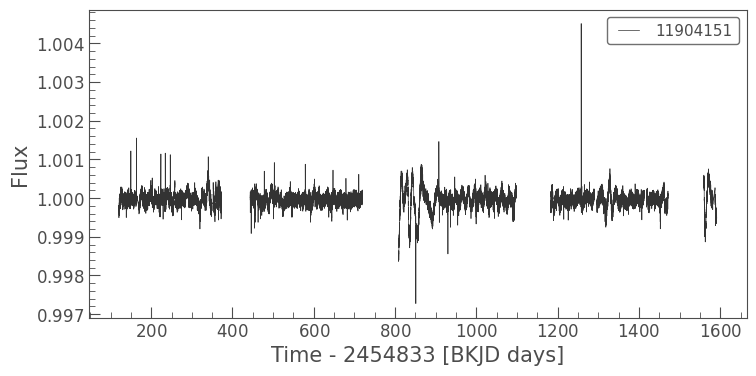

In [3]:
import lightkurve as lk
import os

# Create save directory (relative to notebook location)
SAVE_DIR = "../data/raw"
os.makedirs(SAVE_DIR, exist_ok=True)


def download_lightcurve(kepid):
    """Download and save a Kepler light curve."""
    
    filepath = f"{SAVE_DIR}/kic_{kepid}.fits"
    
    # Skip if already downloaded
    if os.path.exists(filepath):
        print(f"Already exists: {filepath}")
        return lk.read(filepath)
    
    # Search and download
    search = lk.search_lightcurve(f"KIC {kepid}", mission="Kepler", cadence="long")
    
    if len(search) == 0:
        print(f"Not found: KIC {kepid}")
        return None
    
    lc = search.download_all().stitch()
    lc.to_fits(filepath, overwrite=True)
    print(f"Saved: {filepath}")
    
    return lc


# Test
lc = download_lightcurve(11904151)  # Kepler-10
lc.plot()

In [4]:
# Sample Kepler IDs: confirmed planets
planet_kepids = [
    11904151,  # Kepler-10
    10797460,  # Kepler-22
    8191672,   # Kepler-16
    9941662,   # Kepler-36
    6922244,   # Kepler-62
]

# Download
for kepid in planet_kepids:
    download_lightcurve(kepid)
    print()

Already exists: ../data/raw/kic_11904151.fits

Already exists: ../data/raw/kic_10797460.fits

Already exists: ../data/raw/kic_8191672.fits

Already exists: ../data/raw/kic_9941662.fits

Already exists: ../data/raw/kic_6922244.fits



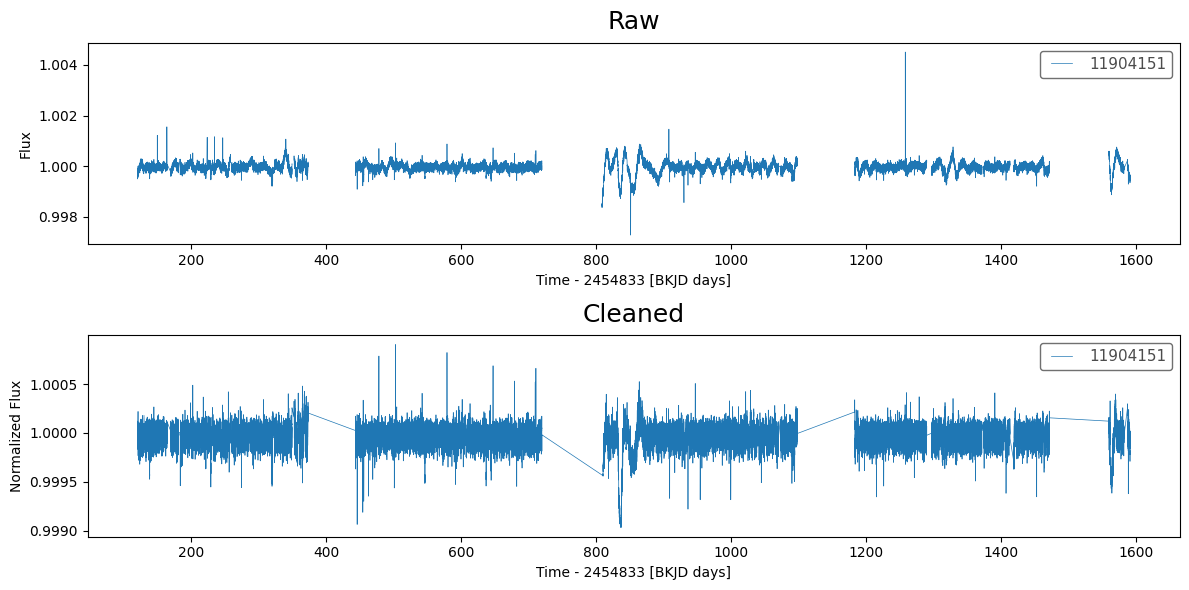

Points: 52195 → 51768


In [5]:
# Prepocessing one light curve
import matplotlib.pyplot as plt

# Load raw
lc_raw = lk.read("../data/raw/kic_11904151.fits")

# Clean
lc = lc_raw.remove_nans()
lc = lc.remove_outliers(sigma=5)
lc = lc.flatten(window_length=401)
lc = lc.normalize()

# Compare
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
lc_raw.plot(ax=axes[0], title="Raw")
lc.plot(ax=axes[1], title="Cleaned")
plt.tight_layout()
plt.show()

print(f"Points: {len(lc_raw)} → {len(lc)}")

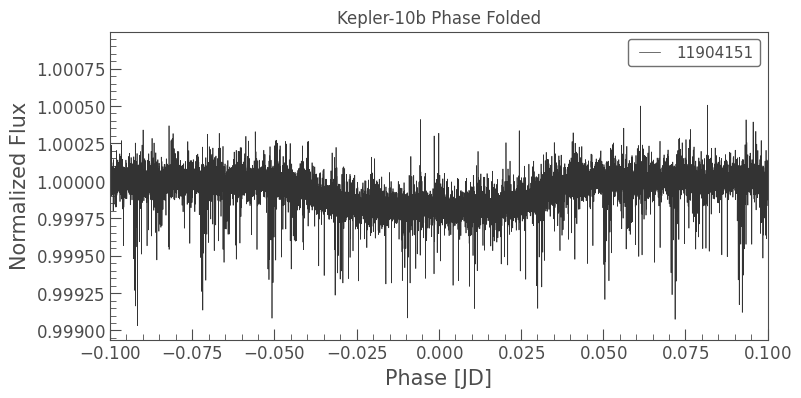

In [6]:
# Kepler-10b orbital period
period = 0.837495  # days
t0 = 131.57507    # first transit time (BKJD)

# Fold all transits onto each other
folded = lc.fold(period=period, epoch_time=t0)

# Plot
folded.plot()
plt.title("Kepler-10b Phase Folded")
plt.xlim(-0.1, 0.1)  # Zoom on transit
plt.show()

Shape: (2000,)
Mean: -0.0000, Std: 1.0000


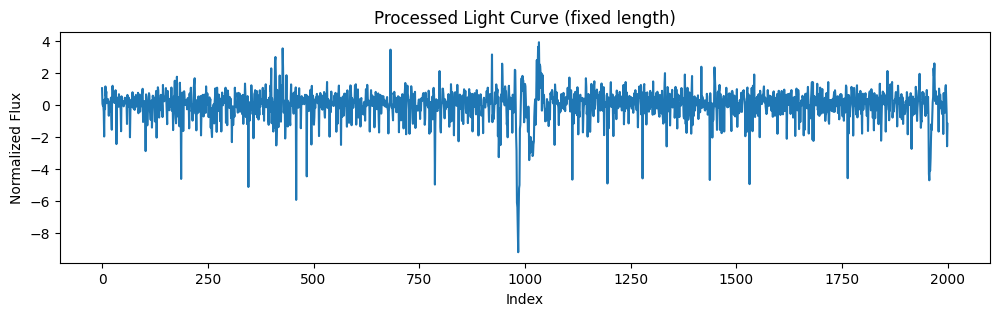

In [7]:
def process_lightcurve(filepath, period=None, t0=None, n_points=2000):
    """
    Load, clean, and convert light curve to fixed-length array.
    
    Parameters:
        filepath: Path to FITS file
        period: Orbital period (if known, will phase fold)
        t0: Epoch of first transit
        n_points: Output array length
    
    Returns:
        flux: numpy array of shape (n_points,)
    """
    
    # Load
    lc = lk.read(filepath)
    
    # Clean
    lc = lc.remove_nans()
    lc = lc.remove_outliers(sigma=5)
    lc = lc.flatten(window_length=401)
    lc = lc.normalize()
    
    # Phase fold if period known
    if period and t0:
        lc = lc.fold(period=period, epoch_time=t0)
    
    # Get flux values
    flux = lc.flux.value
    
    # Resample to fixed length
    from scipy.interpolate import interp1d
    x_old = np.linspace(0, 1, len(flux))
    x_new = np.linspace(0, 1, n_points)
    f = interp1d(x_old, flux, kind='linear', fill_value='extrapolate')
    flux_resampled = f(x_new)
    
    # Normalize to zero mean, unit variance
    flux_resampled = (flux_resampled - np.mean(flux_resampled)) / np.std(flux_resampled)
    
    return flux_resampled


# Test
flux = process_lightcurve("../data/raw/kic_11904151.fits")
print(f"Shape: {flux.shape}")
print(f"Mean: {flux.mean():.4f}, Std: {flux.std():.4f}")

plt.figure(figsize=(12, 3))
plt.plot(flux)
plt.title("Processed Light Curve (fixed length)")
plt.xlabel("Index")
plt.ylabel("Normalized Flux")
plt.show()

In [8]:
# More confirmed planets
planet_kepids = [
    11904151, 10797460, 8191672, 9941662, 6922244,   # Already have
    10593626, 3632418, 7040629, 8866102, 9002278,    # More planets
    5357901, 10874614, 6541920, 10227020, 5728139,
    7303287, 3861595, 9818381, 8684730, 10604335,
]

# False positives (eclipsing binaries) - these mimic transits
false_positive_kepids = [
    1026032, 1162635, 1432789, 1571511, 2162635,
    2302548, 2441495, 2576692, 2715264, 2849125,
    3098810, 3219434, 3339538, 3352358, 3453214,
    3558882, 3662635, 3735712, 3836439, 3935914,
]

print("Downloading planets...")
for kepid in planet_kepids:
    download_lightcurve(kepid)

print("\nDownloading false positives...")
for kepid in false_positive_kepids:
    download_lightcurve(kepid)

Already exists: ../data/raw/kic_11904151.fits
Already exists: ../data/raw/kic_10797460.fits
Already exists: ../data/raw/kic_8191672.fits
Already exists: ../data/raw/kic_9941662.fits
Already exists: ../data/raw/kic_6922244.fits
Already exists: ../data/raw/kic_10593626.fits
Already exists: ../data/raw/kic_3632418.fits
Already exists: ../data/raw/kic_7040629.fits
Already exists: ../data/raw/kic_8866102.fits
Already exists: ../data/raw/kic_9002278.fits
Already exists: ../data/raw/kic_5357901.fits
Already exists: ../data/raw/kic_10874614.fits
Already exists: ../data/raw/kic_6541920.fits
Already exists: ../data/raw/kic_10227020.fits
Already exists: ../data/raw/kic_5728139.fits
Already exists: ../data/raw/kic_7303287.fits
Already exists: ../data/raw/kic_3861595.fits
Already exists: ../data/raw/kic_9818381.fits
Already exists: ../data/raw/kic_8684730.fits
Already exists: ../data/raw/kic_10604335.fits

Already exists: ../data/raw/kic_1026032.fits
Already exists: ../data/raw/kic_1162635.fits
Alr

Could not resolve "KIC 2715264" to a sky position.


Not found: KIC 2715264
Already exists: ../data/raw/kic_2849125.fits
Already exists: ../data/raw/kic_3098810.fits


Could not resolve "KIC 3219434" to a sky position.


Not found: KIC 3219434
Already exists: ../data/raw/kic_3339538.fits


Could not resolve "KIC 3352358" to a sky position.


Not found: KIC 3352358
Already exists: ../data/raw/kic_3453214.fits


Could not resolve "KIC 3558882" to a sky position.


Not found: KIC 3558882
Already exists: ../data/raw/kic_3662635.fits


Could not resolve "KIC 3735712" to a sky position.


Not found: KIC 3735712
Already exists: ../data/raw/kic_3836439.fits
Already exists: ../data/raw/kic_3935914.fits


In [9]:
import os
import numpy as np

def build_dataset(planet_kepids, fp_kepids, n_points=2000):
    """
    Create X (features) and y (labels) arrays.
    
    Labels: 1 = planet, 0 = not planet
    """
    
    X = []
    y = []
    kepids = []
    
    # Process planets (label = 1)
    for kepid in planet_kepids:
        filepath = f"../data/raw/kic_{kepid}.fits"
        if not os.path.exists(filepath):
            continue
        
        try:
            flux = process_lightcurve(filepath, n_points=n_points)
            X.append(flux)
            y.append(1)
            kepids.append(kepid)
        except Exception as e:
            print(f"Error processing {kepid}: {e}")
    
    # Process false positives (label = 0)
    for kepid in fp_kepids:
        filepath = f"../data/raw/kic_{kepid}.fits"
        if not os.path.exists(filepath):
            continue
        
        try:
            flux = process_lightcurve(filepath, n_points=n_points)
            X.append(flux)
            y.append(0)
            kepids.append(kepid)
        except Exception as e:
            print(f"Error processing {kepid}: {e}")
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y, kepids


# Build dataset
X, y, kepids = build_dataset(planet_kepids, false_positive_kepids)

print(f"Dataset shape: {X.shape}")
print(f"Labels: {len(y[y==1])} planets, {len(y[y==0])} non-planets")

# Save for later
np.save("../data/processed/X.npy", X)
np.save("../data/processed/y.npy", y)
print("Saved to data/processed/")

Dataset shape: (35, 2000)
Labels: 20 planets, 15 non-planets
Saved to data/processed/


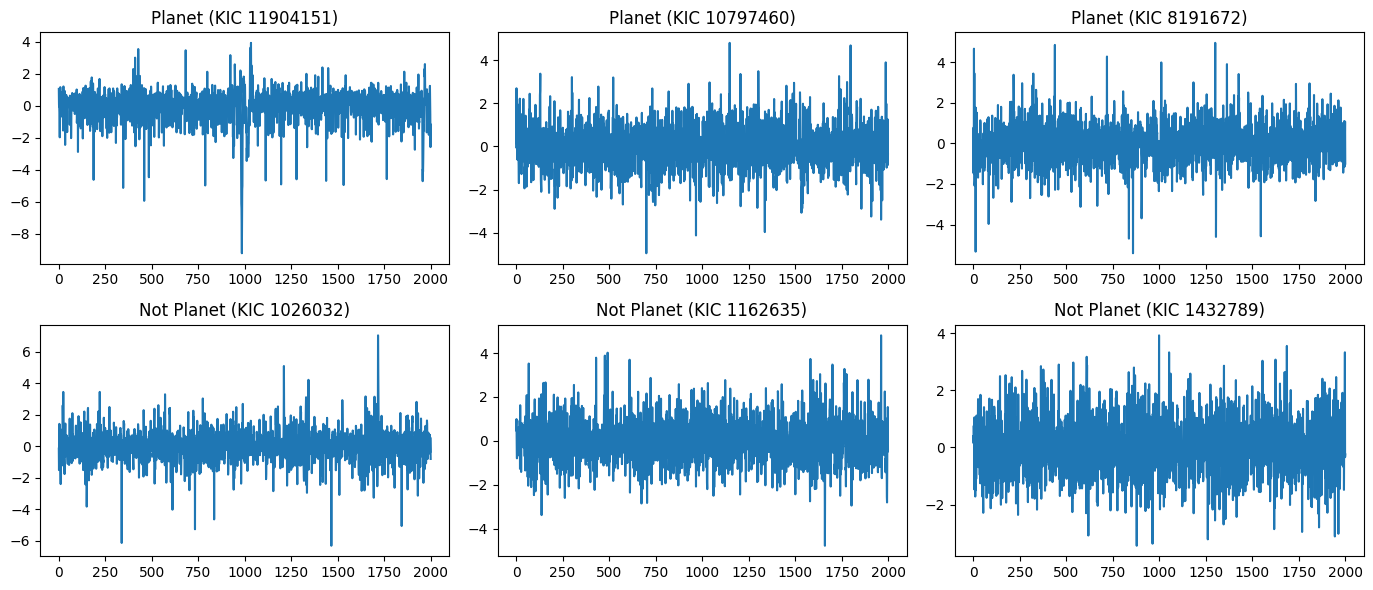

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(14, 6))

# Plot 3 planets
planet_idx = np.where(y == 1)[0][:3]
for i, idx in enumerate(planet_idx):
    axes[0, i].plot(X[idx])
    axes[0, i].set_title(f"Planet (KIC {kepids[idx]})")

# Plot 3 non-planets
fp_idx = np.where(y == 0)[0][:3]
for i, idx in enumerate(fp_idx):
    axes[1, i].plot(X[idx])
    axes[1, i].set_title(f"Not Planet (KIC {kepids[idx]})")

plt.tight_layout()
plt.show()

In [11]:
# Old API endpoint
url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI"
params = "table=q1_q17_dr25_tce&select=kepid,tce_period,tce_depth,tce_duration,av_training_set&format=csv"

df = pd.read_csv(f"{url}?{params}")
print(f"Rows: {len(df)}")
print(df.head())

Rows: 34032
     kepid  tce_period  tce_depth  tce_duration  av_training_set
0  2304168  431.719000    488.400        13.220              NaN
1  2304235    0.570607     75.150         1.160              NaN
2  2304566    0.689480      3.794         5.236              NaN
3  2304320   16.540800    366.700         2.715              NaN
4  2303365    0.520697    123.600         1.035              NaN


In [12]:
import pandas as pd

# Get confirmed planets
url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI"
params = "table=cumulative&select=kepid,koi_period,koi_depth,koi_duration,koi_disposition&format=csv"

df = pd.read_csv(f"{url}?{params}")
print(f"Rows: {len(df)}")
print(df['koi_disposition'].value_counts())
print(df.head())

Rows: 9564
koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64
      kepid  koi_period  koi_depth  koi_duration koi_disposition
0  10797460    9.488036      615.8       2.95750       CONFIRMED
1  10797460   54.418383      874.8       4.50700       CONFIRMED
2  10811496   19.899140    10829.0       1.78220       CANDIDATE
3  10848459    1.736952     8079.2       2.40641  FALSE POSITIVE
4  10854555    2.525592      603.3       1.65450       CONFIRMED


In [13]:
# Create labels: 1 = confirmed planet, 0 = false positive
# Drop candidates (uncertain)
df_labeled = df[df['koi_disposition'] != 'CANDIDATE'].copy()
df_labeled['label'] = (df_labeled['koi_disposition'] == 'CONFIRMED').astype(int)

# Features
feature_cols = ['koi_period', 'koi_depth', 'koi_duration']
df_labeled = df_labeled.dropna(subset=feature_cols)

X = df_labeled[feature_cols].values
y = df_labeled['label'].values

print(f"X shape: {X.shape}")
print(f"Planets: {sum(y==1)}, False positives: {sum(y==0)}")

X shape: (7326, 3)
Planets: 2744, False positives: 4582


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

Train: 5860, Test: 1466


In [15]:
import os

os.makedirs("../data/processed", exist_ok=True)
np.save("../data/processed/X_train.npy", X_train)
np.save("../data/processed/X_test.npy", X_test)
np.save("../data/processed/y_train.npy", y_train)
np.save("../data/processed/y_test.npy", y_test)

print("Saved.")

Saved.


In [16]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Dataset class
class ExoplanetDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataloaders
train_dataset = ExoplanetDataset(X_train, y_train)
test_dataset = ExoplanetDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 184
Test batches: 46


In [17]:
class ExoplanetNN(nn.Module):
    def __init__(self, input_size=3):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x).squeeze()

model = ExoplanetNN()
print(model)

ExoplanetNN(
  (network): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [18]:
# Setup
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        # Forward
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Print every 10 epochs
    if (epoch + 1) % 10 == 0:
        train_loss /= len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}")

print("Training complete.")

Epoch 10/50, Loss: 0.4372
Epoch 20/50, Loss: 0.4111
Epoch 30/50, Loss: 0.3985
Epoch 40/50, Loss: 0.3976
Epoch 50/50, Loss: 0.3831
Training complete.


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Evaluate
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Metrics
print(f"Accuracy:  {accuracy_score(all_labels, all_preds):.4f}")
print(f"Precision: {precision_score(all_labels, all_preds):.4f}")
print(f"Recall:    {recall_score(all_labels, all_preds):.4f}")
print(f"F1 Score:  {f1_score(all_labels, all_preds):.4f}")

print(f"\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

Accuracy:  0.8097
Precision: 0.7109
Recall:    0.8288
F1 Score:  0.7653

Confusion Matrix:
[[732 185]
 [ 94 455]]


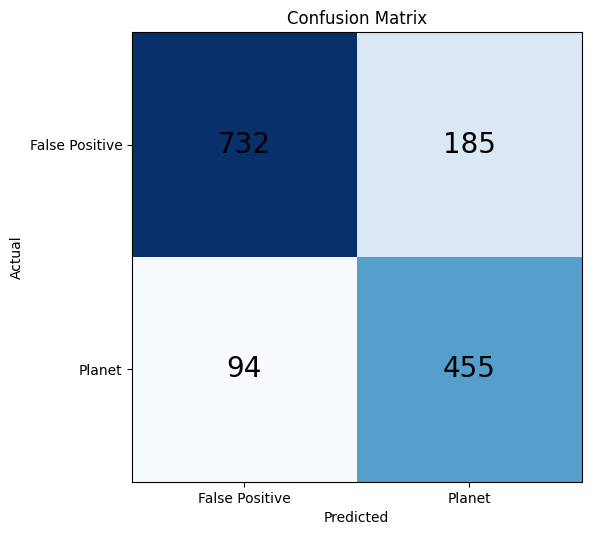

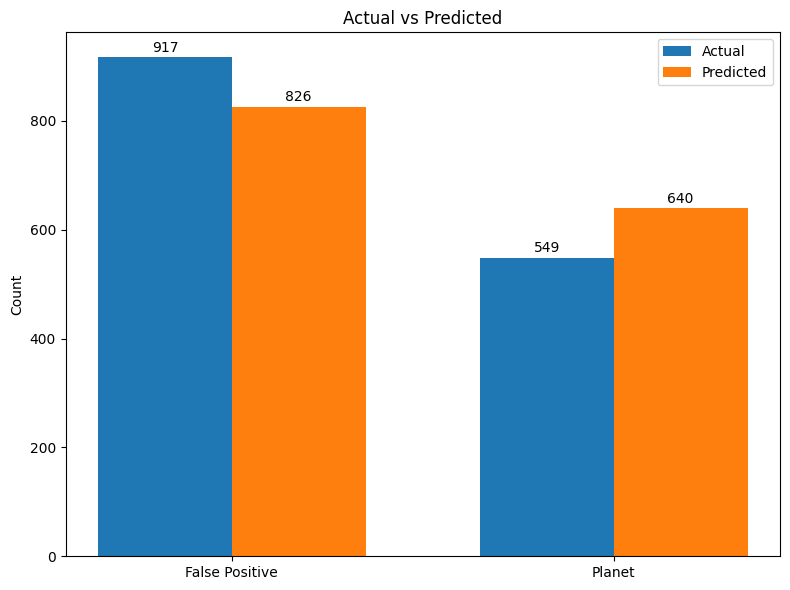

In [20]:
import matplotlib.pyplot as plt


# Confusion matrix plot
cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, cmap='Blues')

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['False Positive', 'Planet'])
ax.set_yticklabels(['False Positive', 'Planet'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

# Add numbers
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', fontsize=20)

plt.tight_layout()
plt.show()

# Count actual vs predicted
actual_planets = sum(all_labels == 1)
actual_fp = sum(all_labels == 0)
pred_planets = sum(all_preds == 1)
pred_fp = sum(all_preds == 0)

# Bar chart
labels = ['False Positive', 'Planet']
actual_counts = [actual_fp, actual_planets]
pred_counts = [pred_fp, pred_planets]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, actual_counts, width, label='Actual')
bars2 = ax.bar(x + width/2, pred_counts, width, label='Predicted')

ax.set_ylabel('Count')
ax.set_title('Actual vs Predicted')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add numbers on bars
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
            int(bar.get_height()), ha='center')
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
            int(bar.get_height()), ha='center')

plt.tight_layout()
plt.show()

In [21]:
# Save model
os.makedirs("../models", exist_ok=True)
torch.save(model.state_dict(), "../models/exoplanet_nn.pt")
print("Model saved.")

Model saved.


In [22]:
print("Beginning model improvements")


Beginning model improvements


In [23]:
class ExoplanetNNv2(nn.Module):
    def __init__(self, input_size=3):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x).squeeze()

# Train v2
model_v2 = ExoplanetNNv2()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_v2.parameters(), lr=0.001)

for epoch in range(100):
    model_v2.train()
    for X_batch, y_batch in train_loader:
        outputs = model_v2(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/100, Loss: {loss.item():.4f}")

# Evaluate v2
model_v2.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model_v2(X_batch)
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print(f"\nV2 Results:")
print(f"Accuracy:  {accuracy_score(all_labels, all_preds):.4f}")
print(f"Precision: {precision_score(all_labels, all_preds):.4f}")
print(f"Recall:    {recall_score(all_labels, all_preds):.4f}")
print(f"F1 Score:  {f1_score(all_labels, all_preds):.4f}")

Epoch 20/100, Loss: 0.5405
Epoch 40/100, Loss: 0.4544
Epoch 60/100, Loss: 0.3277
Epoch 80/100, Loss: 0.6698
Epoch 100/100, Loss: 0.4879

V2 Results:
Accuracy:  0.8165
Precision: 0.7303
Recall:    0.8087
F1 Score:  0.7675


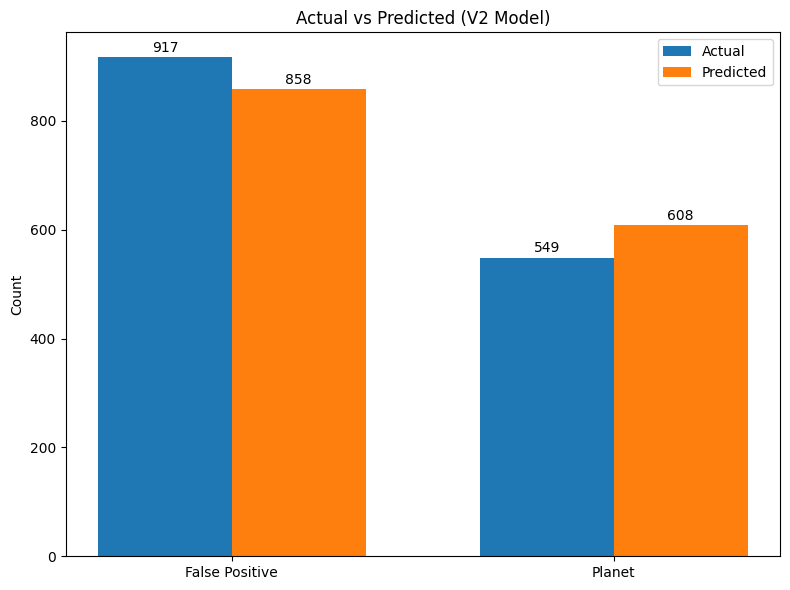

In [24]:
# Bar chart comparison
actual_planets = sum(all_labels == 1)
actual_fp = sum(all_labels == 0)
pred_planets = sum(all_preds == 1)
pred_fp = sum(all_preds == 0)

labels = ['False Positive', 'Planet']
actual_counts = [actual_fp, actual_planets]
pred_counts = [pred_fp, pred_planets]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, actual_counts, width, label='Actual')
bars2 = ax.bar(x + width/2, pred_counts, width, label='Predicted')

ax.set_ylabel('Count')
ax.set_title('Actual vs Predicted (V2 Model)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
            int(bar.get_height()), ha='center')
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
            int(bar.get_height()), ha='center')

plt.tight_layout()
plt.show()

In [25]:
torch.save(model_v2.state_dict(), "../models/exoplanet_nn_v2.pt")
print("V2 model saved.")

V2 model saved.


In [26]:
print("Adding more planet features to improve model performance.")

Adding more planet features to improve model performance.


In [27]:
# Get more features
url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI"
params = "table=cumulative&select=kepid,koi_period,koi_depth,koi_duration,koi_prad,koi_teq,koi_insol,koi_steff,koi_srad,koi_model_snr,koi_disposition&format=csv"

df = pd.read_csv(f"{url}?{params}")

# Filter and create labels
df = df[df['koi_disposition'] != 'CANDIDATE'].copy()
df['label'] = (df['koi_disposition'] == 'CONFIRMED').astype(int)

# More features
feature_cols = ['koi_period', 'koi_depth', 'koi_duration', 'koi_prad', 
                'koi_teq', 'koi_insol', 'koi_steff', 'koi_srad', 'koi_model_snr']
df = df.dropna(subset=feature_cols)

X = df[feature_cols].values
y = df['label'].values

print(f"X shape: {X.shape}")
print(f"Planets: {sum(y==1)}, FP: {sum(y==0)}")

X shape: (7326, 9)
Planets: 2744, FP: 4582


In [28]:
print("Retraining model with additional features...")
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create dataloaders
train_dataset = ExoplanetDataset(X_train, y_train)
test_dataset = ExoplanetDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")
print(f"Features: {X_train.shape[1]}")

Retraining model with additional features...
Train: 5860, Test: 1466
Features: 9


In [29]:
class ExoplanetNNv3(nn.Module):
    def __init__(self, input_size=9):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x).squeeze()

# Train
model_v3 = ExoplanetNNv3(input_size=9)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_v3.parameters(), lr=0.001)

for epoch in range(100):
    model_v3.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        outputs = model_v3(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/100, Loss: {total_loss/len(train_loader):.4f}")

Epoch 20/100, Loss: 0.3620
Epoch 40/100, Loss: 0.3573
Epoch 60/100, Loss: 0.3292
Epoch 80/100, Loss: 0.3328
Epoch 100/100, Loss: 0.3220


In [30]:
model_v3.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model_v3(X_batch)
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print(f"\nV3 Results (9 features):")
print(f"Accuracy:  {accuracy_score(all_labels, all_preds):.4f}")
print(f"Precision: {precision_score(all_labels, all_preds):.4f}")
print(f"Recall:    {recall_score(all_labels, all_preds):.4f}")
print(f"F1 Score:  {f1_score(all_labels, all_preds):.4f}")


V3 Results (9 features):
Accuracy:  0.8213
Precision: 0.6833
Recall:    0.9745
F1 Score:  0.8033


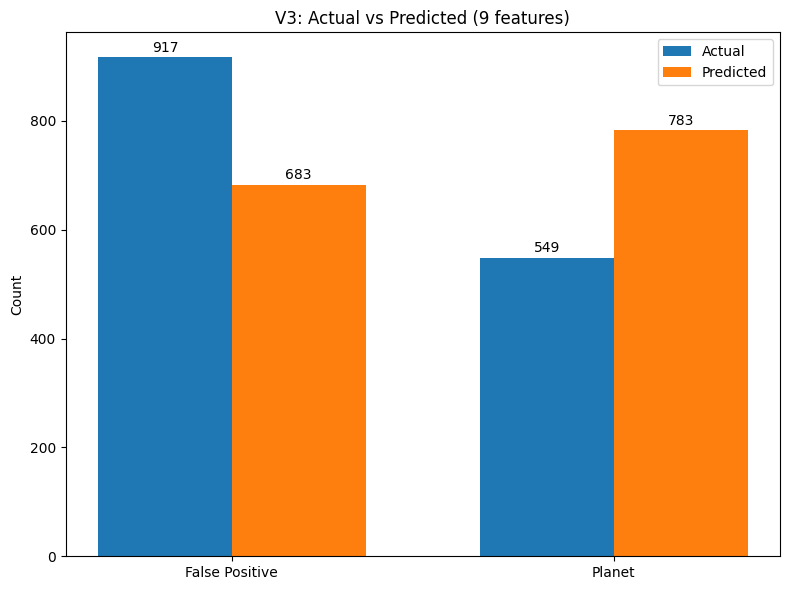


Confusion Matrix:
[[669 248]
 [ 14 535]]


In [31]:
actual_planets = sum(all_labels == 1)
actual_fp = sum(all_labels == 0)
pred_planets = sum(all_preds == 1)
pred_fp = sum(all_preds == 0)

labels = ['False Positive', 'Planet']
actual_counts = [actual_fp, actual_planets]
pred_counts = [pred_fp, pred_planets]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, actual_counts, width, label='Actual')
bars2 = ax.bar(x + width/2, pred_counts, width, label='Predicted')

ax.set_ylabel('Count')
ax.set_title('V3: Actual vs Predicted (9 features)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
            int(bar.get_height()), ha='center')
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
            int(bar.get_height()), ha='center')

plt.tight_layout()
plt.show()

print(f"\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

In [32]:
# Try different thresholds
model_v3.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model_v3(X_batch)
        all_probs.extend(outputs.numpy())
        all_labels.extend(y_batch.numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

print("Threshold | Accuracy | Precision | Recall | F1")
print("-" * 50)
for thresh in [0.3, 0.4, 0.5, 0.6, 0.7]:
    preds = (all_probs > thresh).astype(float)
    acc = accuracy_score(all_labels, preds)
    prec = precision_score(all_labels, preds)
    rec = recall_score(all_labels, preds)
    f1 = f1_score(all_labels, preds)
    print(f"   {thresh}     |  {acc:.4f}  |  {prec:.4f}   | {rec:.4f} | {f1:.4f}")

Threshold | Accuracy | Precision | Recall | F1
--------------------------------------------------
   0.3     |  0.7763  |  0.6272   | 0.9927 | 0.7687
   0.4     |  0.8035  |  0.6590   | 0.9854 | 0.7898
   0.5     |  0.8213  |  0.6833   | 0.9745 | 0.8033
   0.6     |  0.8431  |  0.7170   | 0.9599 | 0.8209
   0.7     |  0.8581  |  0.7541   | 0.9217 | 0.8295


In [33]:
# Save model
torch.save(model_v3.state_dict(), "../models/exoplanet_nn_v3.pt")

# Save scaler for future predictions
import pickle
with open("../models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Model and scaler saved.")
print("Optimal threshold: 0.7")

Model and scaler saved.
Optimal threshold: 0.7


                      Model  Accuracy  Precision  Recall     F1
            V1 (3 features)    0.8076     0.7251  0.7832 0.7531
            V2 (3 features)    0.8165     0.7303  0.8087 0.7675
V3 (9 features, thresh=0.7)    0.8581     0.7541  0.9217 0.8295


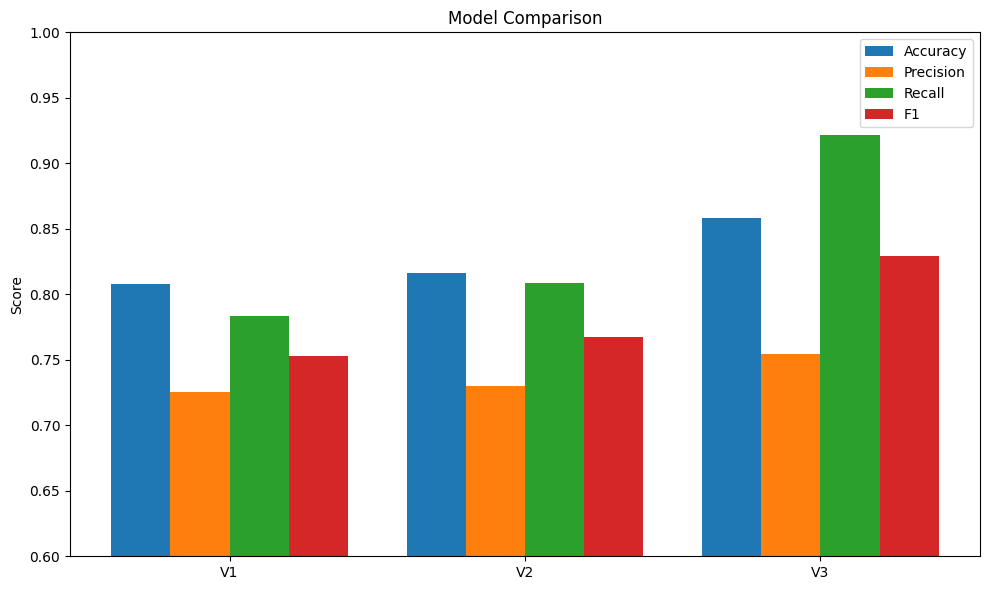

In [34]:
results = {
    'Model': ['V1 (3 features)', 'V2 (3 features)', 'V3 (9 features, thresh=0.7)'],
    'Accuracy': [0.8076, 0.8165, 0.8581],
    'Precision': [0.7251, 0.7303, 0.7541],
    'Recall': [0.7832, 0.8087, 0.9217],
    'F1': [0.7531, 0.7675, 0.8295]
}

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(results['Model']))
width = 0.2

ax.bar(x - 1.5*width, results['Accuracy'], width, label='Accuracy')
ax.bar(x - 0.5*width, results['Precision'], width, label='Precision')
ax.bar(x + 0.5*width, results['Recall'], width, label='Recall')
ax.bar(x + 1.5*width, results['F1'], width, label='F1')

ax.set_ylabel('Score')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(['V1', 'V2', 'V3'])
ax.legend()
ax.set_ylim(0.6, 1.0)

plt.tight_layout()
plt.show()

In [35]:
import pickle

def predict_planet(features, threshold=0.7):
    """
    Predict if features indicate a planet.
    
    Parameters:
        features: dict with keys: koi_period, koi_depth, koi_duration, 
                  koi_prad, koi_teq, koi_insol, koi_steff, koi_srad, koi_model_snr
        threshold: classification threshold (default 0.7)
    
    Returns:
        prediction: 'Planet' or 'False Positive'
        probability: model confidence
    """
    
    # Load scaler
    with open("../models/scaler.pkl", "rb") as f:
        scaler = pickle.load(f)
    
    # Load model
    model = ExoplanetNNv3(input_size=9)
    model.load_state_dict(torch.load("../models/exoplanet_nn_v3.pt"))
    model.eval()
    
    # Prepare features
    feature_order = ['koi_period', 'koi_depth', 'koi_duration', 'koi_prad',
                     'koi_teq', 'koi_insol', 'koi_steff', 'koi_srad', 'koi_model_snr']
    X = np.array([[features[f] for f in feature_order]])
    X = scaler.transform(X)
    X = torch.tensor(X, dtype=torch.float32)
    
    # Predict
    with torch.no_grad():
        prob = model(X).item()
    
    prediction = "Planet" if prob > threshold else "False Positive"
    
    return prediction, prob


# Test with a real example from our data
test_example = {
    'koi_period': 9.488,
    'koi_depth': 615.8,
    'koi_duration': 2.957,
    'koi_prad': 2.35,
    'koi_teq': 585.0,
    'koi_insol': 27.5,
    'koi_steff': 5627.0,
    'koi_srad': 1.06,
    'koi_model_snr': 45.2
}

pred, prob = predict_planet(test_example)
print(f"Prediction: {pred}")
print(f"Probability: {prob:.4f}")

Prediction: Planet
Probability: 0.8855


In [36]:
# Get candidates (unconfirmed)
url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI"
params = "table=cumulative&select=kepid,kepoi_name,koi_period,koi_depth,koi_duration,koi_prad,koi_teq,koi_insol,koi_steff,koi_srad,koi_model_snr,koi_disposition&format=csv"

df_all = pd.read_csv(f"{url}?{params}")

# Filter to candidates only
df_candidates = df_all[df_all['koi_disposition'] == 'CANDIDATE'].copy()

# Drop rows with missing features
feature_cols = ['koi_period', 'koi_depth', 'koi_duration', 'koi_prad',
                'koi_teq', 'koi_insol', 'koi_steff', 'koi_srad', 'koi_model_snr']
df_candidates = df_candidates.dropna(subset=feature_cols)

print(f"Candidates to predict: {len(df_candidates)}")
print(df_candidates.head())

Candidates to predict: 1875
       kepid kepoi_name  koi_period  koi_depth  koi_duration  koi_prad  \
2   10811496  K00753.01   19.899140    10829.0        1.7822     14.60   
58  11818800  K00777.01   40.419504     6256.0        3.3620      7.51   
62  11918099  K00780.02    7.240661      556.4        0.5580     19.45   
63   9579641  K00115.03    3.435916       23.2        3.1330      0.55   
84   3115833  K00797.01   10.181584     5741.1        3.5089      7.73   

    koi_teq  koi_insol  koi_steff  koi_srad  koi_model_snr koi_disposition  
2     638.0      39.30     5853.0     0.868           76.3       CANDIDATE  
58    467.0      11.29     5446.0     0.781           36.9       CANDIDATE  
62    734.0      68.63     5005.0     0.765           13.7       CANDIDATE  
63   1272.0     617.61     5779.0     1.087            8.7       CANDIDATE  
84    812.0     102.91     5988.0     0.836          183.6       CANDIDATE  


In [37]:
# Prepare features
X_candidates = df_candidates[feature_cols].values
X_candidates_scaled = scaler.transform(X_candidates)
X_tensor = torch.tensor(X_candidates_scaled, dtype=torch.float32)

# Predict
model_v3.eval()
with torch.no_grad():
    probabilities = model_v3(X_tensor).numpy()

# Add predictions to dataframe
df_candidates['planet_probability'] = probabilities
df_candidates['prediction'] = (probabilities > 0.7).astype(int)
df_candidates['prediction_label'] = df_candidates['prediction'].map({1: 'Likely Planet', 0: 'Likely False Positive'})

print(f"\nPredictions:")
print(df_candidates['prediction_label'].value_counts())


Predictions:
prediction_label
Likely Planet            1068
Likely False Positive     807
Name: count, dtype: int64


In [38]:
# Sort by probability
df_likely_planets = df_candidates.sort_values('planet_probability', ascending=False)

print("Top 15 Most Likely Planets:")
print(df_likely_planets[['kepoi_name', 'koi_period', 'koi_prad', 'planet_probability']].head(15).to_string(index=False))

Top 15 Most Likely Planets:
kepoi_name  koi_period  koi_prad  planet_probability
 K02298.01   16.667141      0.70            0.914677
 K00430.02    9.340538      0.84            0.914557
 K05974.01    4.768155      0.49            0.914477
 K04509.01   12.003678      0.97            0.914469
 K07617.01   12.928455      0.64            0.914263
 K06568.01    6.276516      0.65            0.914056
 K04622.02    4.501582      0.73            0.914049
 K06475.01    4.845060      1.54            0.913976
 K02174.01    6.693328      2.44            0.913935
 K08037.01    3.650345      0.72            0.913915
 K04859.01    7.501974      1.19            0.913872
 K00255.02   13.603208      0.75            0.913838
 K01427.02    4.884466      0.84            0.913777
 K03444.01   12.671437      0.76            0.913768
 K04957.02    4.987924      0.73            0.913714


In [39]:
# Near the decision boundary
df_uncertain = df_candidates[
    (df_candidates['planet_probability'] > 0.5) & 
    (df_candidates['planet_probability'] < 0.8)
].sort_values('planet_probability', ascending=False)

print(f"\nUncertain cases ({len(df_uncertain)}):")
print(df_uncertain[['kepoi_name', 'koi_period', 'koi_prad', 'planet_probability']].head(10).to_string(index=False))


Uncertain cases (404):
kepoi_name  koi_period  koi_prad  planet_probability
 K03041.01    5.082881      1.15            0.799446
 K00525.01   11.530293      3.98            0.799432
 K04856.01  147.388124      3.03            0.799365
 K07169.01   10.511378      0.72            0.798752
 K06291.01    8.832419      0.98            0.798733
 K07272.01   14.101102      1.26            0.798117
 K02357.01    2.420883      2.27            0.797124
 K01963.01   12.896236      2.55            0.797118
 K02976.01   21.613134      1.94            0.797111
 K07634.01   80.840690     15.11            0.797090


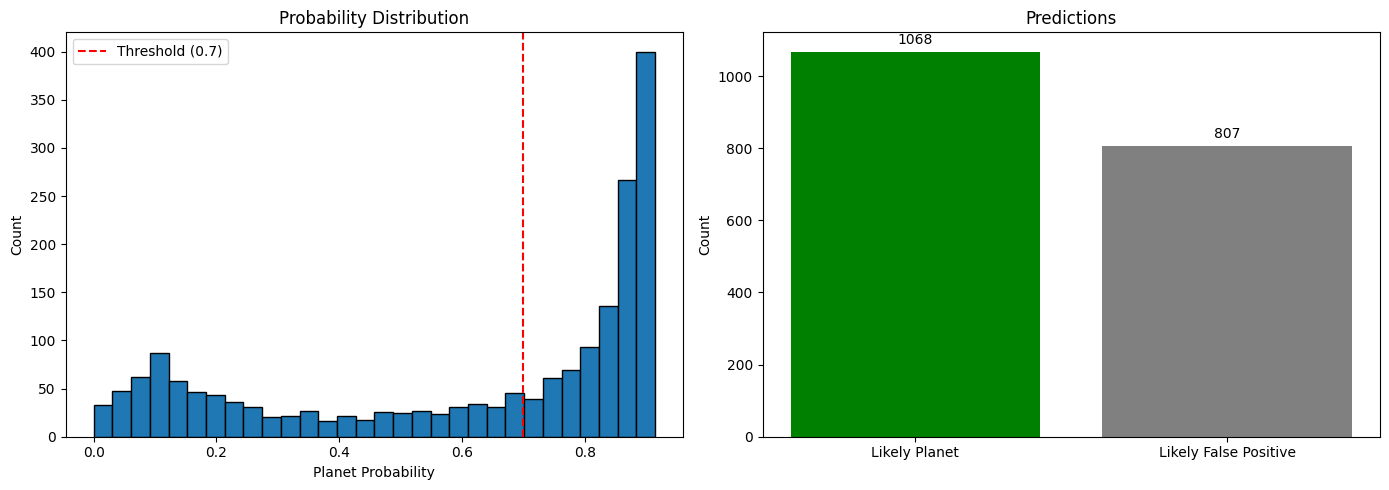

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of probabilities
axes[0].hist(df_candidates['planet_probability'], bins=30, edgecolor='black')
axes[0].axvline(x=0.7, color='red', linestyle='--', label='Threshold (0.7)')
axes[0].set_xlabel('Planet Probability')
axes[0].set_ylabel('Count')
axes[0].set_title('Probability Distribution')
axes[0].legend()

# Prediction counts
counts = df_candidates['prediction_label'].value_counts()
axes[1].bar(counts.index, counts.values, color=['green', 'gray'])
axes[1].set_ylabel('Count')
axes[1].set_title('Predictions')
for i, v in enumerate(counts.values):
    axes[1].text(i, v + 20, str(v), ha='center')

plt.tight_layout()
plt.show()

In [41]:
# Compare likely planets vs likely false positives
likely_planets = df_candidates[df_candidates['prediction'] == 1]
likely_fp = df_candidates[df_candidates['prediction'] == 0]

print("Feature Comparison (median values):")
print(f"\n{'Feature':<20} {'Likely Planets':>15} {'Likely FP':>15}")
print("-" * 52)

for col in feature_cols:
    planet_med = likely_planets[col].median()
    fp_med = likely_fp[col].median()
    print(f"{col:<20} {planet_med:>15.2f} {fp_med:>15.2f}")

Feature Comparison (median values):

Feature               Likely Planets       Likely FP
----------------------------------------------------
koi_period                     10.71          143.16
koi_depth                     180.25          391.10
koi_duration                    3.45            4.19
koi_prad                        1.38            2.55
koi_teq                       808.00          444.00
koi_insol                     100.79            9.18
koi_steff                    5663.50         5829.00
koi_srad                        0.95            1.10
koi_model_snr                  11.20           10.80


In [42]:
# Save to CSV
output_cols = ['kepoi_name', 'kepid', 'koi_period', 'koi_prad', 'planet_probability', 'prediction_label']
df_candidates[output_cols].to_csv("../results/candidate_predictions.csv", index=False)

print("Saved to results/candidate_predictions.csv")

Saved to results/candidate_predictions.csv


In [43]:
# Filter: small radius (< 2 Earth radii) and moderate temperature (200-350K)
potentially_habitable = df_candidates[
    (df_candidates['koi_prad'] < 2.0) &
    (df_candidates['koi_teq'] > 200) &
    (df_candidates['koi_teq'] < 350) &
    (df_candidates['prediction'] == 1)
].sort_values('planet_probability', ascending=False)

print(f"Potentially Habitable Candidates: {len(potentially_habitable)}")
print(potentially_habitable[['kepoi_name', 'koi_period', 'koi_prad', 'koi_teq', 'planet_probability']].head(10).to_string(index=False))

Potentially Habitable Candidates: 20
kepoi_name  koi_period  koi_prad  koi_teq  planet_probability
 K07617.01   12.928455      0.64    343.0            0.914263
 K07099.01   34.035777      1.05    337.0            0.911896
 K03391.01   36.766236      1.28    336.0            0.905506
 K02862.01   24.575252      1.64    316.0            0.904683
 K02719.02  106.259760      1.50    303.0            0.900729
 K04926.01   69.089357      1.47    332.0            0.898469
 K03034.01   31.020917      1.66    291.0            0.898067
 K02124.01   42.337580      1.45    311.0            0.897855
 K07882.01   65.415183      1.31    295.0            0.896668
 K05098.01  100.345648      1.57    325.0            0.896475


In [44]:
# Get confirmed planets list
url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI"
params = "table=cumulative&select=kepoi_name,koi_disposition&where=koi_disposition='CONFIRMED'&format=csv"

df_confirmed = pd.read_csv(f"{url}?{params}")
confirmed_names = set(df_confirmed['kepoi_name'].values)

print(f"Total confirmed planets: {len(confirmed_names)}")

Total confirmed planets: 2746


In [46]:
# Get NASA's confidence scores for candidates
url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI"
params = "table=cumulative&select=kepoi_name,koi_score,koi_disposition&format=csv"

df_scores = pd.read_csv(f"{url}?{params}")
df_scores = df_scores.dropna(subset=['koi_score'])

print(f"Entries with NASA scores: {len(df_scores)}")
print(df_scores.head())

Entries with NASA scores: 8054
  kepoi_name  koi_score koi_disposition
0  K00752.01      1.000       CONFIRMED
1  K00752.02      0.969       CONFIRMED
2  K00753.01      0.000       CANDIDATE
3  K00754.01      0.000  FALSE POSITIVE
4  K00755.01      1.000       CONFIRMED


In [47]:
# Merge
df_validation = df_candidates[['kepoi_name', 'planet_probability', 'prediction_label']].merge(
    df_scores[['kepoi_name', 'koi_score']],
    on='kepoi_name',
    how='inner'
)

print(f"Candidates we can validate: {len(df_validation)}")
print(df_validation.head(10))

Candidates we can validate: 1372
  kepoi_name  planet_probability       prediction_label  koi_score
0  K00753.01            0.477765  Likely False Positive      0.000
1  K00777.01            0.776551          Likely Planet      0.999
2  K00780.02            0.807549          Likely Planet      0.993
3  K00115.03            0.862988          Likely Planet      0.871
4  K00797.01            0.823626          Likely Planet      1.000
5  K00802.01            0.234170  Likely False Positive      1.000
6  K00815.01            0.778636          Likely Planet      1.000
7  K00820.01            0.017275  Likely False Positive      0.000
8  K00868.01            0.558512  Likely False Positive      0.998
9  K00856.01            0.525082  Likely False Positive      0.994


Correlation with NASA: 0.3979


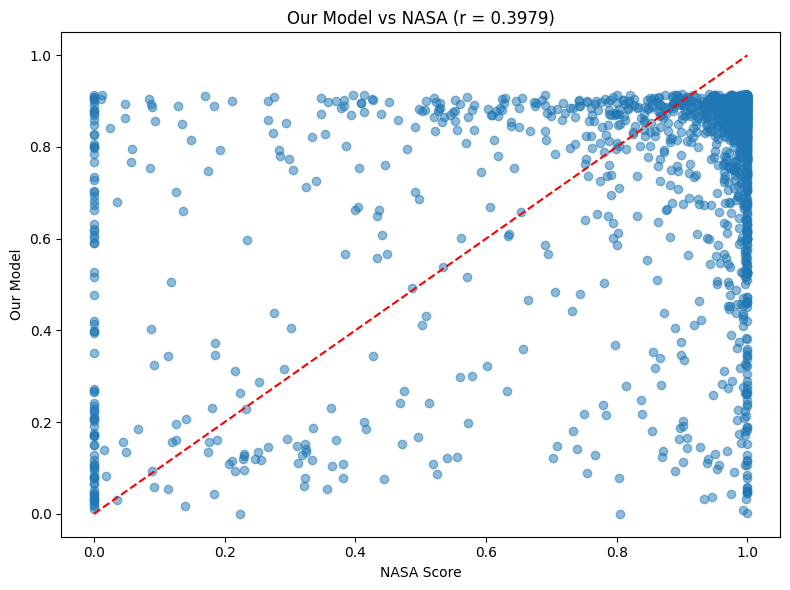

In [48]:
# Correlation
correlation = df_validation['planet_probability'].corr(df_validation['koi_score'])
print(f"Correlation with NASA: {correlation:.4f}")

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_validation['koi_score'], df_validation['planet_probability'], alpha=0.5)
plt.xlabel('NASA Score')
plt.ylabel('Our Model')
plt.title(f'Our Model vs NASA (r = {correlation:.4f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.tight_layout()
plt.show()

In [49]:
# Categorize agreement
df_validation['nasa_prediction'] = (df_validation['koi_score'] > 0.5).astype(int)
df_validation['our_prediction'] = (df_validation['planet_probability'] > 0.7).astype(int)

# Agreement matrix
agree_planet = ((df_validation['nasa_prediction'] == 1) & (df_validation['our_prediction'] == 1)).sum()
agree_fp = ((df_validation['nasa_prediction'] == 0) & (df_validation['our_prediction'] == 0)).sum()
we_say_planet = ((df_validation['nasa_prediction'] == 0) & (df_validation['our_prediction'] == 1)).sum()
nasa_says_planet = ((df_validation['nasa_prediction'] == 1) & (df_validation['our_prediction'] == 0)).sum()

print("Agreement Matrix:")
print(f"\n{'':25} {'NASA: Planet':>15} {'NASA: FP':>15}")
print("-" * 55)
print(f"{'Our Model: Planet':<25} {agree_planet:>15} {we_say_planet:>15}")
print(f"{'Our Model: FP':<25} {nasa_says_planet:>15} {agree_fp:>15}")

total = len(df_validation)
agreement_rate = (agree_planet + agree_fp) / total
print(f"\nOverall Agreement: {agreement_rate:.1%}")

Agreement Matrix:

                             NASA: Planet        NASA: FP
-------------------------------------------------------
Our Model: Planet                     864              83
Our Model: FP                         280             145

Overall Agreement: 73.5%


In [50]:
# Cases where we disagree most
df_validation['disagreement'] = abs(df_validation['planet_probability'] - df_validation['koi_score'])

# We say planet, NASA says no
we_say_yes = df_validation[
    (df_validation['our_prediction'] == 1) & 
    (df_validation['nasa_prediction'] == 0)
].sort_values('disagreement', ascending=False)

print(f"\nWe say Planet, NASA says FP ({len(we_say_yes)} cases):")
print(we_say_yes[['kepoi_name', 'planet_probability', 'koi_score']].head(10).to_string(index=False))

# NASA says planet, we say no
nasa_says_yes = df_validation[
    (df_validation['our_prediction'] == 0) & 
    (df_validation['nasa_prediction'] == 1)
].sort_values('disagreement', ascending=False)

print(f"\nNASA says Planet, we say FP ({len(nasa_says_yes)} cases):")
print(nasa_says_yes[['kepoi_name', 'planet_probability', 'koi_score']].head(10).to_string(index=False))


We say Planet, NASA says FP (83 cases):
kepoi_name  planet_probability  koi_score
 K01194.02            0.913563      0.000
 K04097.02            0.909573      0.000
 K04846.01            0.906079      0.000
 K03444.04            0.904562      0.000
 K02882.01            0.900668      0.000
 K03119.01            0.912248      0.013
 K01884.01            0.904436      0.011
 K03936.01            0.891700      0.000
 K06195.01            0.880751      0.000
 K03072.01            0.879274      0.000

NASA says Planet, we say FP (280 cases):
kepoi_name  planet_probability  koi_score
 K00971.01            0.000758      1.000
 K02093.03            0.007485      0.994
 K06401.01            0.033043      0.998
 K02548.01            0.045745      1.000
 K02813.01            0.045835      1.000
 K05287.01            0.049552      1.000
 K07430.01            0.050710      1.000
 K04546.01            0.055705      1.000
 K05566.01            0.059296      1.000
 K07865.01            0.043473     

In [51]:
# Both strongly agree it's a planet
strong_planets = df_validation[
    (df_validation['planet_probability'] > 0.85) &
    (df_validation['koi_score'] > 0.85)
].sort_values('planet_probability', ascending=False)

print(f"\nStrong Agreement - Likely Planets ({len(strong_planets)}):")
print(strong_planets[['kepoi_name', 'planet_probability', 'koi_score']].head(10).to_string(index=False))


Strong Agreement - Likely Planets (466):
kepoi_name  planet_probability  koi_score
 K02298.01            0.914677      0.900
 K00430.02            0.914557      0.998
 K05974.01            0.914477      0.993
 K04509.01            0.914469      0.942
 K06568.01            0.914056      0.951
 K04622.02            0.914049      0.977
 K06475.01            0.913976      1.000
 K02174.01            0.913935      0.973
 K08037.01            0.913915      1.000
 K00255.02            0.913838      0.997


In [52]:
# Look at features of disagreement cases
# We say yes, NASA says no
we_yes_nasa_no = df_candidates[df_candidates['kepoi_name'].isin(we_say_yes['kepoi_name'].head(10))]

# NASA says yes, we say no
nasa_yes_we_no = df_candidates[df_candidates['kepoi_name'].isin(nasa_says_yes['kepoi_name'].head(10))]

print("Features where WE say Planet, NASA says No:")
print(we_yes_nasa_no[['kepoi_name', 'koi_period', 'koi_depth', 'koi_prad', 'koi_model_snr']].to_string(index=False))

print("\nFeatures where NASA says Planet, WE say No:")
print(nasa_yes_we_no[['kepoi_name', 'koi_period', 'koi_depth', 'koi_prad', 'koi_model_snr']].to_string(index=False))

Features where WE say Planet, NASA says No:
kepoi_name  koi_period  koi_depth  koi_prad  koi_model_snr
 K01194.02   14.862308      840.0      1.57           14.4
 K01884.01   23.117072     2407.5      4.37           61.2
 K02882.01   75.858003     1148.4      2.72           16.1
 K03119.01    2.184438     1546.8      0.94           19.7
 K03072.01   24.336703      551.1      1.95           13.4
 K04097.02    4.449023       88.9      0.55           10.4
 K04846.01   19.254536      186.0      1.32            9.2
 K03936.01  141.608555     1263.1      2.98           43.3
 K03444.04   14.150231      208.1      0.74            9.3
 K06195.01    1.444486      980.7      1.73           12.0

Features where NASA says Planet, WE say No:
kepoi_name  koi_period  koi_depth  koi_prad  koi_model_snr
 K00971.01    0.533059     1495.8    133.56          179.6
 K02548.01    0.827151      272.4     19.10            8.1
 K02813.01    0.698461      134.4     14.81           16.1
 K04546.01    0.741768    

In [53]:
# Compare median features
feature_cols = ['koi_period', 'koi_depth', 'koi_duration', 'koi_prad', 'koi_model_snr']

we_yes_nasa_no_features = df_candidates[df_candidates['kepoi_name'].isin(we_say_yes['kepoi_name'])]
nasa_yes_we_no_features = df_candidates[df_candidates['kepoi_name'].isin(nasa_says_yes['kepoi_name'])]
both_agree = df_candidates[df_candidates['kepoi_name'].isin(strong_planets['kepoi_name'])]

print(f"{'Feature':<15} {'Both Agree':>12} {'We Yes/NASA No':>15} {'NASA Yes/We No':>15}")
print("-" * 60)
for col in feature_cols:
    agree_med = both_agree[col].median()
    we_med = we_yes_nasa_no_features[col].median()
    nasa_med = nasa_yes_we_no_features[col].median()
    print(f"{col:<15} {agree_med:>12.2f} {we_med:>15.2f} {nasa_med:>15.2f}")

Feature           Both Agree  We Yes/NASA No  NASA Yes/We No
------------------------------------------------------------
koi_period             10.23           23.12           19.75
koi_depth             184.95          320.80          359.90
koi_duration            3.49            4.01            3.09
koi_prad                1.34            1.76            2.81
koi_model_snr          11.60           12.00           14.75


In [54]:
# Save validation results
df_validation.to_csv("../results/validation_vs_nasa.csv", index=False)

# Summary stats
summary = {
    'Total Candidates Evaluated': len(df_validation),
    'Agreement Rate': f"{agreement_rate:.1%}",
    'Strong Planet Candidates': len(strong_planets),
    'Correlation with NASA': f"{correlation:.4f}",
    'Our Model Precision (vs NASA)': f"{agree_planet / (agree_planet + we_say_planet):.1%}",
    'Our Model Recall (vs NASA)': f"{agree_planet / (agree_planet + nasa_says_planet):.1%}"
}

print("\n=== Final Summary ===")
for k, v in summary.items():
    print(f"{k}: {v}")


=== Final Summary ===
Total Candidates Evaluated: 1372
Agreement Rate: 73.5%
Strong Planet Candidates: 466
Correlation with NASA: 0.3979
Our Model Precision (vs NASA): 91.2%
Our Model Recall (vs NASA): 75.5%


In [55]:
# Save models and results
torch.save(model_v3.state_dict(), "../models/exoplanet_nn_v3.pt")

# Save strong candidates list
strong_planets_full = df_candidates[df_candidates['kepoi_name'].isin(strong_planets['kepoi_name'])]
strong_planets_full.to_csv("../results/strong_planet_candidates.csv", index=False)

print(f"Saved {len(strong_planets_full)} strong candidates to results/strong_planet_candidates.csv")

Saved 466 strong candidates to results/strong_planet_candidates.csv
